# NMF analysis on calcium movies

In [1]:
import os

# standard libraries
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# custom library
from patchnmf.data_io import get_tiff, get_save_path, export_conts_fiji
from patchnmf.analyse.compute import downsample_tiff_avg, compute_nmfpx_blur_thr, get_thr_img_auto, get_roi_conts, get_loading_times 
from patchnmf.plot import plot_nmf_t, plot_nmfpx_blur_thr, plot_rois_overlay, plot_roi_conts_largest, plot_roi_area_hist, plot_px_nmf_corr, plot_roi_loading_time

# going to root directory (if not there yet)
current_dir = os.getcwd().split('/')[-1]
if current_dir != 'barrel-patch_analysis': 
    os.chdir('..')

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Setting parameters

In [2]:
# defining analysis parameters
ds = 'ani98_XXXX-XX-XX_a'

n_components = 20
blur_std = 6.5
downs_fact = 4 # keep as 1 for no downsampling IMPORTANT: downsampling will mean fewer significant components in cross-validation
resolution = 1.2 # in um 

## Loading and pre-processing tiff

mot_corr_concat.tiff
Shape of video: (3600, 405, 405)


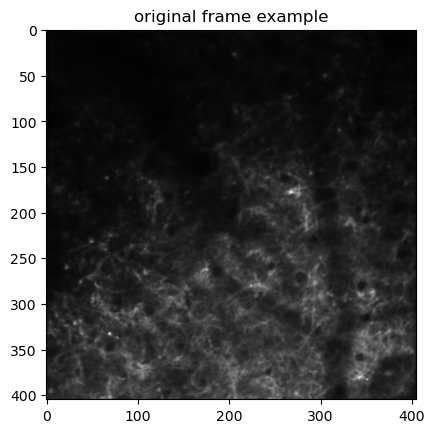

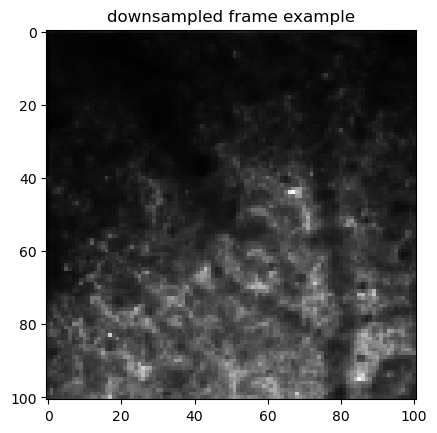

In [3]:
tiff = get_tiff(ds)
tiff = downsample_tiff_avg(tiff, n=downs_fact) # downsample (to speed up cross-validation) -> not done if downs_fact = 1

In [4]:
# flattening movie to input it to NMF (Negative *Matrix* Factorisation works on matrices, not tensors like movies)
# but its not problem because the results that we get can then be easily reshaped back into an x by y frame (FOV)
tiff_flat = np.reshape(tiff, (tiff.shape[0] , tiff.shape[1]*tiff.shape[2]))
print(f'Shape of video as a matrix (input to NMF): {tiff_flat.shape}') 

Shape of video as a matrix (input to NMF): (3600, 164025)


# NMF on pixels

In [5]:
#initialising nmf and fitting to pixels
nmf_px = NMF(n_components=n_components)
nmf_px.fit(tiff_flat);

In [6]:
# here we get the raw NMF component on pixels, raw NMF with gaussin blur and an automatically thresholded blurred NMF (binary 'ROI')
loading_imgs, loading_imgs_filt, rois_auto = compute_nmfpx_blur_thr(nmf_px, tiff.shape, blur_std=blur_std)

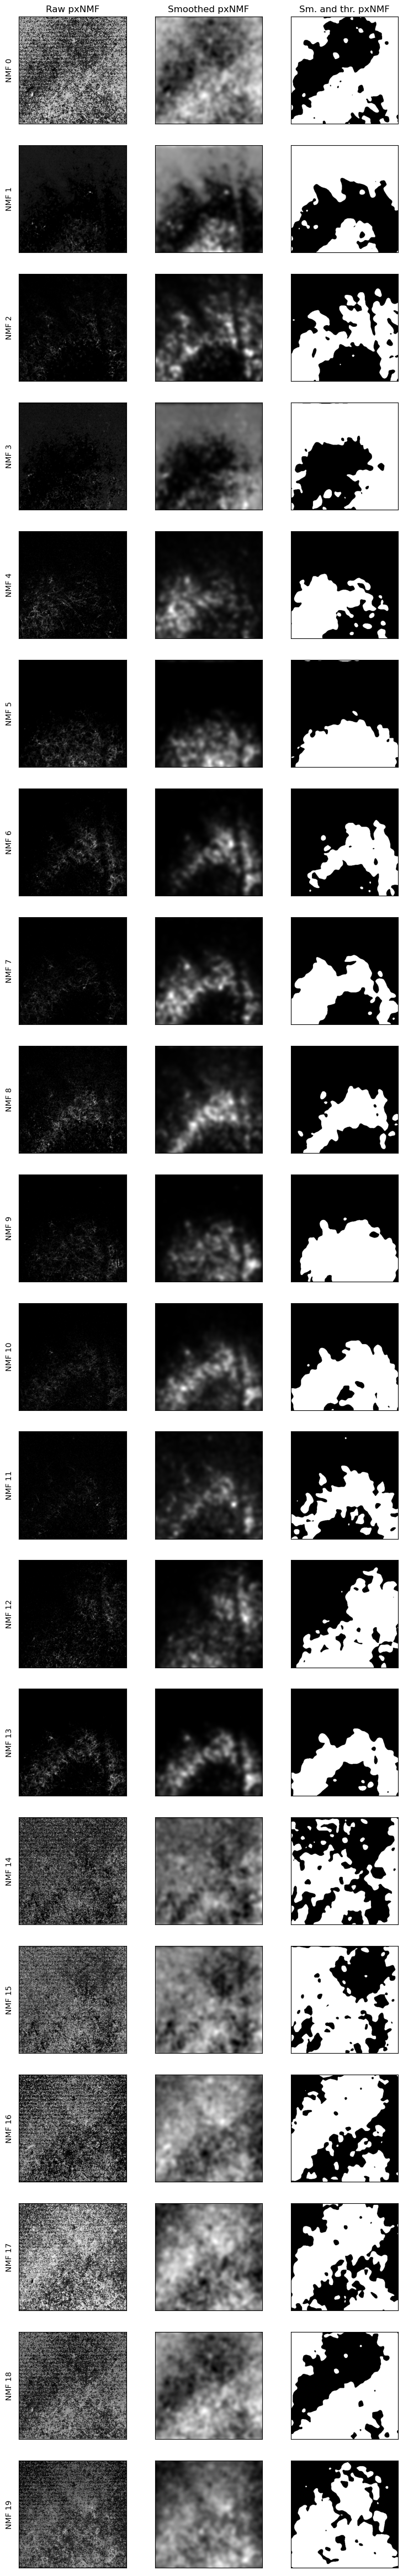

In [7]:
plot_nmfpx_blur_thr(loading_imgs, loading_imgs_filt, rois_auto)

<Figure size 1000x1000 with 0 Axes>

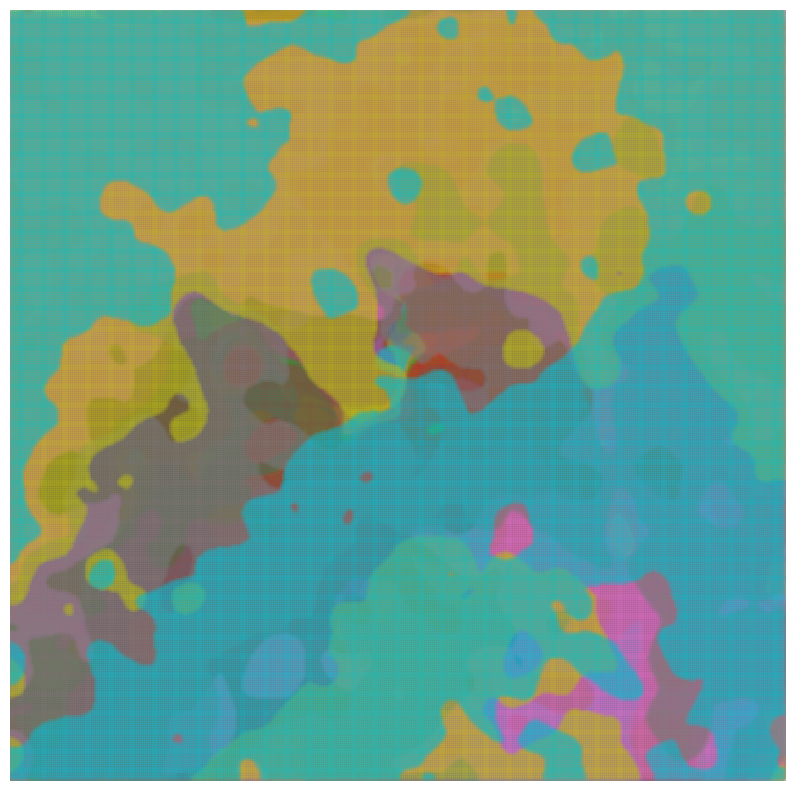

In [8]:
plot_rois_overlay(rois_auto, tiff.shape) # this will look ugly for too many components, also probably not the best viusalisation

In [9]:
# this is a function that takes ROIs as a binary image (as above) and outputs the coordinates of points that would encircle them
conts, n_conts = get_roi_conts(rois_auto)

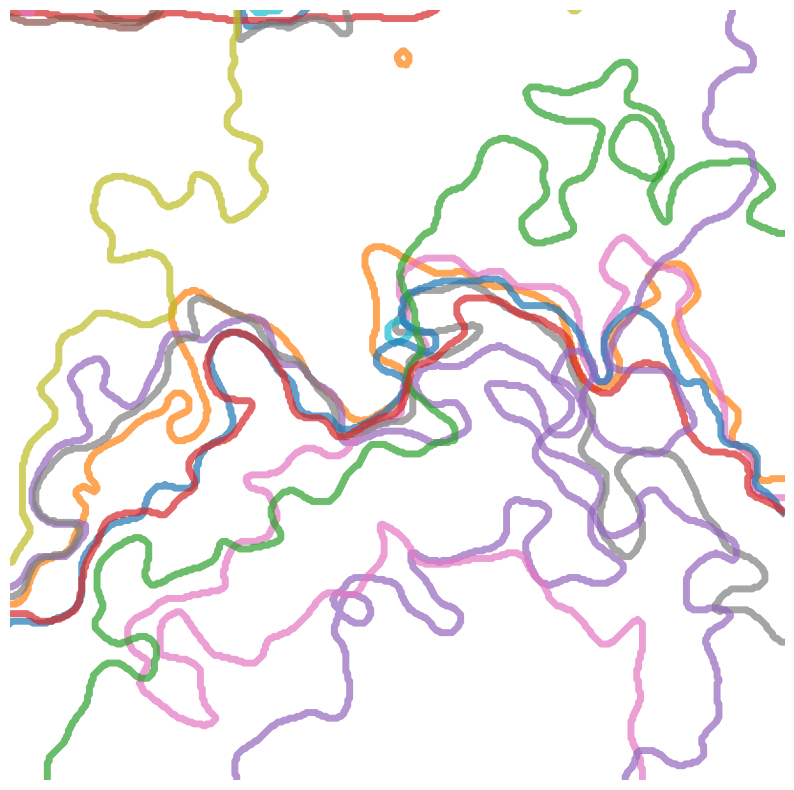

In [10]:
plot_roi_conts_largest(conts, tiff.shape)

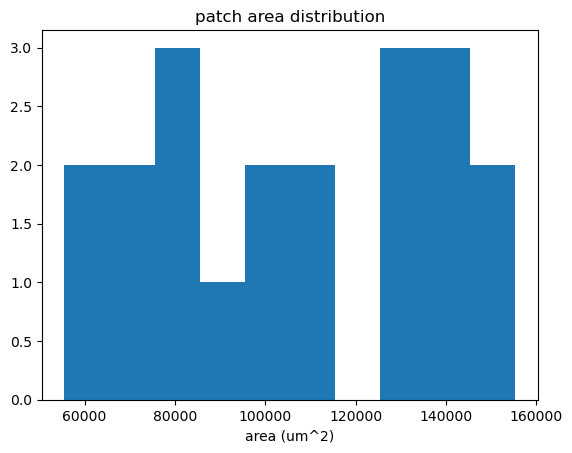

In [11]:
plot_roi_area_hist(rois_auto, n_bins=10, resolution=resolution)

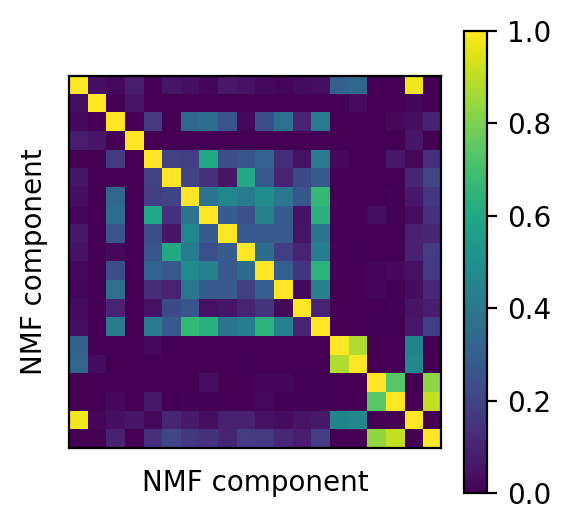

In [12]:
# looking at correlation (in the binary case this is somewhat equivalent to the percentage of overlap)
# NOTE: this plot is deceiving because it only shows positive correlations - it saturates the negative ones
plot_px_nmf_corr(nmf_px)

# NMF on time

In [13]:
# Initialising nmf and fitting to time
nmf_t = NMF(n_components=n_components)
nmf_t.fit(tiff_flat.T);

In [14]:
loading_times = get_loading_times(nmf_t)

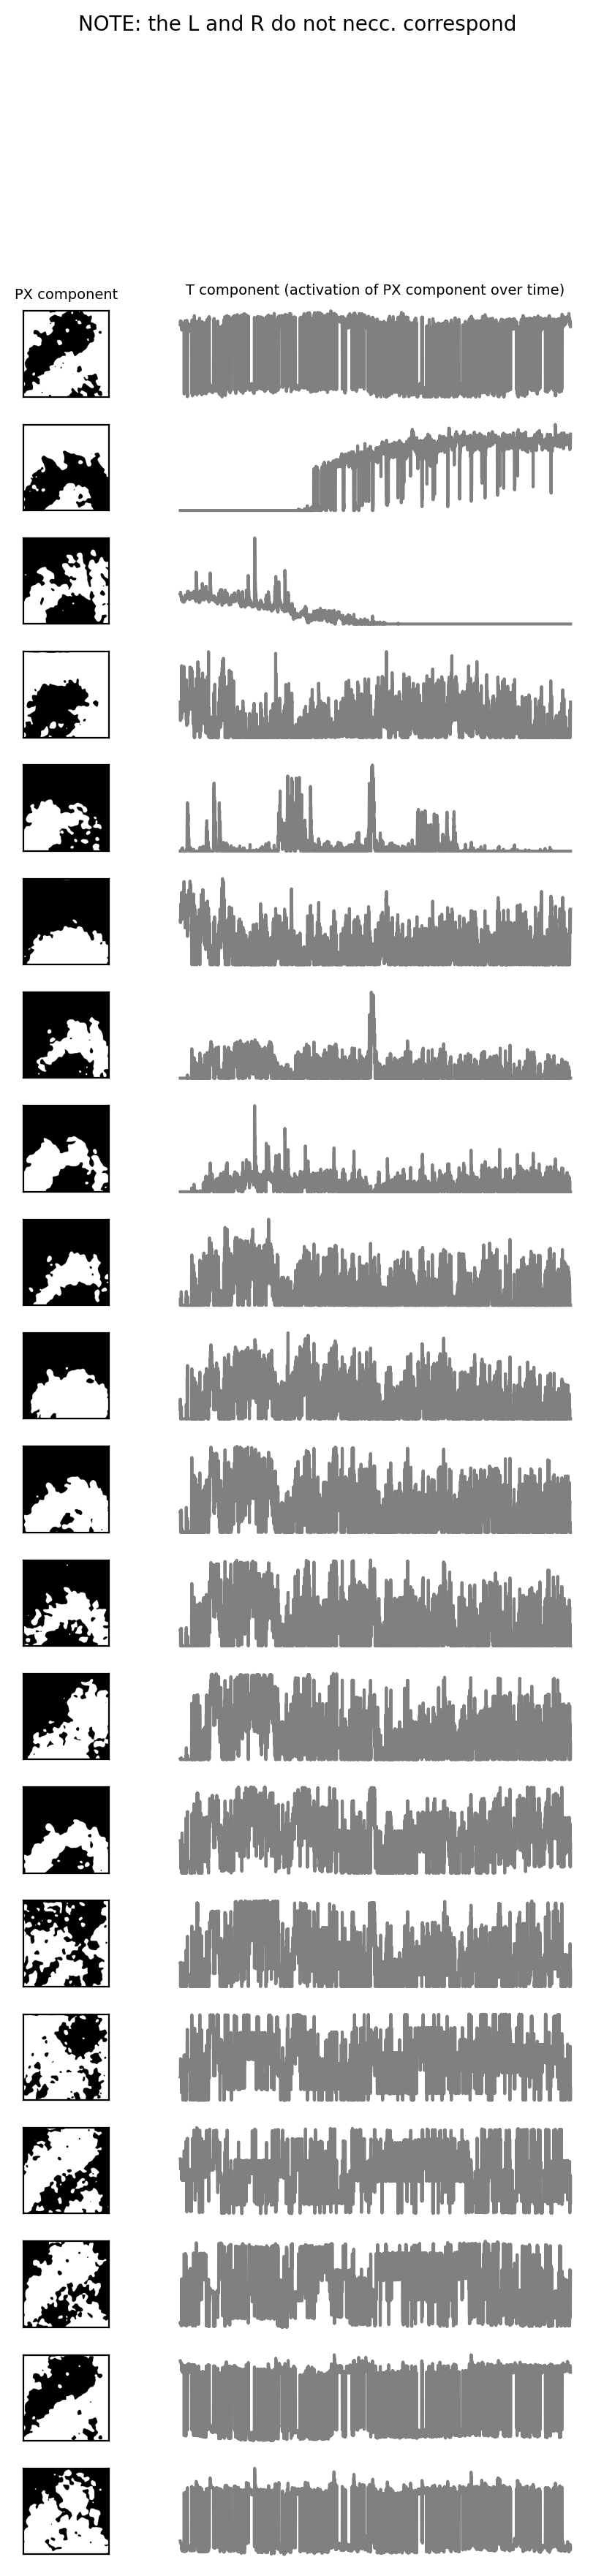

In [15]:
plot_roi_loading_time(rois_auto, loading_times)

# Saving variables

In [16]:
# saving ROIs as text files to import in FIJI
save_path = get_save_path(ds)
export_conts_fiji(conts, save_path)

SavePath:  /home/jure/Documents/code/barrel-patch_analysis/data/ani98_XXXX-XX-XX_a/patch_sz/


In [17]:
# variables to save
tiff_dimred_exp = {'loading_imgs': loading_imgs,
                   'loading_times': loading_times,
                   'rois_auto': rois_auto,
                   'conts': conts}

In [18]:
np.save(f'{save_path}/export_tiff_dimred.npy', tiff_dimred_exp, allow_pickle=True)